### OpenCV DNN 패키지를 이용하여 MASK R-CNN 기반의 Object Detection/Instance Segmentation 수행
* Tensorflow 에서 Pretrained 된 모델 파일을 OpenCV에서 로드하여 이미지와 영상에 대한 Object Detection 수행.

#### 입력 이미지로 사용될 이미지 다운로드/보기

In [1]:
!mkdir /content/data
!wget -O ./data/beatles01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg

--2023-11-18 09:01:58--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383118 (374K) [image/jpeg]
Saving to: ‘./data/beatles01.jpg’

./data/beatles01.jp 100%[===================>] 374.14K  --.-KB/s    in 0.05s   

2023-11-18 09:01:59 (7.25 MB/s) - ‘./data/beatles01.jpg’ saved [383118/383118]



image shape: (633, 806, 3)


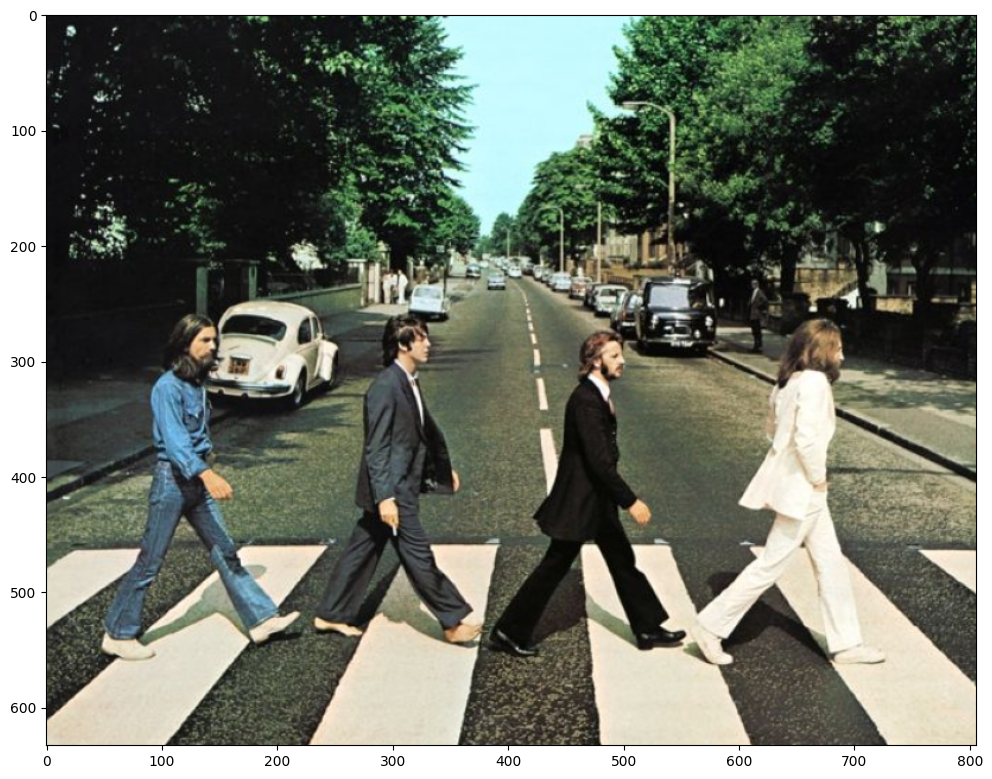

In [2]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

img = cv2.imread('./data/beatles01.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print('image shape:', img.shape)
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

#### Tensorflow에서 Pretrained 된 Inference모델(Frozen graph)와 환경파일을 다운로드 받은 후 이를 이용해 OpenCV에서 Inference 모델 생성
* https://github.com/opencv/opencv/wiki/TensorFlow-Object-Detection-API 에 다운로드 URL 있음.
* pretrained 모델은 http://download.tensorflow.org/models/object_detection/mask_rcnn_inception_v2_coco_2018_01_28.tar.gz 에서 다운로드 후 압축 해제
* pretrained 모델을 위한 환경 파일은 https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt 에서 다운로드
* download된 모델 파일과 config 파일을 인자로 하여 inference 모델을 DNN에서 로딩함.


In [3]:
!mkdir ./pretrained
!wget -O ./pretrained/mask_rcnn_inception_v2_coco_2018_01_28.tar.gz http://download.tensorflow.org/models/object_detection/mask_rcnn_inception_v2_coco_2018_01_28.tar.gz
!wget -O ./pretrained/config_mask_graph.pbtxt https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt

--2023-11-18 09:02:01--  http://download.tensorflow.org/models/object_detection/mask_rcnn_inception_v2_coco_2018_01_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.26.207, 172.217.193.207, 172.217.204.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.26.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 177817887 (170M) [application/x-tar]
Saving to: ‘./pretrained/mask_rcnn_inception_v2_coco_2018_01_28.tar.gz’

./pretrained/mask_r 100%[===================>] 169.58M   177MB/s    in 1.0s    

2023-11-18 09:02:02 (177 MB/s) - ‘./pretrained/mask_rcnn_inception_v2_coco_2018_01_28.tar.gz’ saved [177817887/177817887]

--2023-11-18 09:02:02--  https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubuse

In [4]:
!tar -xvf ./pretrained/mask*.tar.gz -C ./pretrained

mask_rcnn_inception_v2_coco_2018_01_28/
mask_rcnn_inception_v2_coco_2018_01_28/model.ckpt.index
mask_rcnn_inception_v2_coco_2018_01_28/checkpoint
mask_rcnn_inception_v2_coco_2018_01_28/pipeline.config
mask_rcnn_inception_v2_coco_2018_01_28/model.ckpt.data-00000-of-00001
mask_rcnn_inception_v2_coco_2018_01_28/model.ckpt.meta
mask_rcnn_inception_v2_coco_2018_01_28/saved_model/
mask_rcnn_inception_v2_coco_2018_01_28/saved_model/saved_model.pb
mask_rcnn_inception_v2_coco_2018_01_28/saved_model/variables/
mask_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb


In [5]:
!pwd
!ls -lia ./pretrained/mask_rcnn_inception_v2_coco_2018_01_28

/content
total 132684
3276867 drwxr-xr-x 3 345018 5000     4096 Feb  1  2018 .
3276864 drwxr-xr-x 3 root   root     4096 Nov 18 09:02 ..
3276869 -rw-r--r-- 1 345018 5000       77 Feb  1  2018 checkpoint
3276878 -rw-r--r-- 1 345018 5000 67138064 Feb  1  2018 frozen_inference_graph.pb
3276871 -rw-r--r-- 1 345018 5000 63616508 Feb  1  2018 model.ckpt.data-00000-of-00001
3276868 -rw-r--r-- 1 345018 5000    16123 Feb  1  2018 model.ckpt.index
3276872 -rw-r--r-- 1 345018 5000  5069133 Feb  1  2018 model.ckpt.meta
3276870 -rw-r--r-- 1 345018 5000     3776 Feb  1  2018 pipeline.config
3276873 drwxr-xr-x 3 345018 5000     4096 Feb  1  2018 saved_model


#### dnn에서 readNetFromTensorflow()로 tensorflow inference 모델을 로딩 후 Inference 수행
* cv_net.forward() 수행 시 Bounding box Inference(bbox regression, bbox classification)과 mask inference 결과를 함께 출력하기 위해 layer명 detection_out_final, detection_masks 결과 가져옴

In [6]:
cv_net = cv2.dnn.readNetFromTensorflow('./pretrained/mask_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb',
                                     './pretrained/config_mask_graph.pbtxt')
blob = cv2.dnn.blobFromImage(img , swapRB=True, crop=False)
cv_net.setInput(blob)

# Bounding box 정보는 detection_out_final layer에서 mask 정보는 detection_masks layer에서 추출.
boxes, masks = cv_net.forward(['detection_out_final', 'detection_masks']) # out_final은 bbox와 classf, masks는 mask prediction

In [7]:
layer_names = cv_net.getLayerNames()
layer_names

('Preprocessor/mul',
 'Preprocessor/sub',
 'FirstStageFeatureExtractor/InceptionV2/InceptionV2/Conv2d_1a_7x7/separable_conv2d/depthwise',
 'FirstStageFeatureExtractor/InceptionV2/InceptionV2/Conv2d_1a_7x7/separable_conv2d',
 'FirstStageFeatureExtractor/InceptionV2/InceptionV2/Conv2d_1a_7x7/BatchNorm/FusedBatchNorm',
 'FirstStageFeatureExtractor/InceptionV2/InceptionV2/Conv2d_1a_7x7/Relu',
 'FirstStageFeatureExtractor/InceptionV2/InceptionV2/MaxPool_2a_3x3/MaxPool',
 'FirstStageFeatureExtractor/InceptionV2/InceptionV2/Conv2d_2b_1x1/Conv2D',
 'FirstStageFeatureExtractor/InceptionV2/InceptionV2/Conv2d_2b_1x1/BatchNorm/FusedBatchNorm',
 'FirstStageFeatureExtractor/InceptionV2/InceptionV2/Conv2d_2b_1x1/Relu',
 'FirstStageFeatureExtractor/InceptionV2/InceptionV2/Conv2d_2c_3x3/Conv2D',
 'FirstStageFeatureExtractor/InceptionV2/InceptionV2/Conv2d_2c_3x3/BatchNorm/FusedBatchNorm',
 'FirstStageFeatureExtractor/InceptionV2/InceptionV2/Conv2d_2c_3x3/Relu',
 'FirstStageFeatureExtractor/InceptionV2/I

#### coco 데이터 세트의 클래스id별 클래스명 지정.

In [8]:
# coco dataset의 클래스 ID별 클래스명 매핑
labels_to_names_seq= {0:'person',1:'bicycle',2:'car',3:'motorcycle',4:'airplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',
                    10:'fire hydrant',11:'street sign',12:'stop sign',13:'parking meter',14:'bench',15:'bird',16:'cat',17:'dog',18:'horse',19:'sheep',
                    20:'cow',21:'elephant',22:'bear',23:'zebra',24:'giraffe',25:'hat',26:'backpack',27:'umbrella',28:'shoe',29:'eye glasses',
                    30:'handbag',31:'tie',32:'suitcase',33:'frisbee',34:'skis',35:'snowboard',36:'sports ball',37:'kite',38:'baseball bat',39:'baseball glove',
                    40:'skateboard',41:'surfboard',42:'tennis racket',43:'bottle',44:'plate',45:'wine glass',46:'cup',47:'fork',48:'knife',49:'spoon',
                    50:'bowl',51:'banana',52:'apple',53:'sandwich',54:'orange',55:'broccoli',56:'carrot',57:'hot dog',58:'pizza',59:'donut',
                    60:'cake',61:'chair',62:'couch',63:'potted plant',64:'bed',65:'mirror',66:'dining table',67:'window',68:'desk',69:'toilet',
                    70:'door',71:'tv',72:'laptop',73:'mouse',74:'remote',75:'keyboard',76:'cell phone',77:'microwave',78:'oven',79:'toaster',
                    80:'sink',81:'refrigerator',82:'blender',83:'book',84:'clock',85:'vase',86:'scissors',87:'teddy bear',88:'hair drier',89:'toothbrush',
                    90:'hair brush'}



#masking 시 클래스별 컬러 적용
colors = list(
    [[0, 255, 0],
     [0, 0, 255],
     [255, 0, 0],
     [0, 255, 255],
     [255, 255, 0],
     [255, 0, 255],
     [80, 70, 180],
     [250, 80, 190],
     [245, 145, 50],
     [70, 150, 250],
     [50, 190, 190]] )

In [9]:
# bbox 정보는  찾아낸 object 갯수별로(여기서는 100개), class_id, class confidence score,  bbox 좌표등 7개의 정보로 구성. 개
# masking 정보는 object 갯수별로 90개의 coco class 별로 15x15의 masking 으로 구성.
print('boxes shape:', boxes.shape, 'masks shape:', masks.shape)

boxes shape: (1, 1, 100, 7) masks shape: (100, 90, 15, 15)


#### Detect된 Object에 대해서 bounding box와 mask를 시각화
* 이미지를 mask 설명을 위해서 Detected된 모든 object를 시각화 하지 않고 단 하나의 object만 시각화 수행(iteration을 한번만 수행)

In [10]:
masks[0,0] # mask 확률값. 이 value로 mask_threshold보다 크면 1 아니면 0으로 표현 가능

array([[5.05760872e-05, 1.51210270e-05, 1.30302342e-05, 3.26758345e-05,
        1.25406135e-04, 1.59948110e-03, 1.72130279e-02, 9.73477364e-02,
        1.82077482e-01, 1.63199112e-01, 8.77496451e-02, 2.59186774e-02,
        3.98626272e-03, 5.24562609e-04, 4.42848250e-04],
       [7.68209702e-06, 3.63517097e-06, 5.46004139e-06, 4.70144878e-05,
        7.34739879e-04, 3.25886831e-02, 5.68575263e-01, 9.57904041e-01,
        9.86125648e-01, 9.72700953e-01, 8.33623290e-01, 3.00408810e-01,
        1.79047715e-02, 7.47655286e-04, 2.44054259e-04],
       [6.13484781e-06, 3.92934135e-06, 1.21724024e-05, 2.97148566e-04,
        6.27432810e-03, 1.55845687e-01, 8.96822155e-01, 9.92803156e-01,
        9.95611727e-01, 9.74058032e-01, 6.47799075e-01, 1.12822771e-01,
        6.54230453e-03, 1.94253531e-04, 5.53994651e-05],
       [1.16873061e-05, 9.90795706e-06, 5.14323110e-05, 2.26755626e-03,
        7.80571476e-02, 7.39746928e-01, 9.90540266e-01, 9.98218358e-01,
        9.96732950e-01, 9.16382074e-0

In [11]:
boxes.shape, masks.shape

((1, 1, 100, 7), (100, 90, 15, 15))

In [12]:
import numpy as np

numClasses = masks.shape[1]
numDetections = boxes.shape[2] # detection할 이미지 갯수

# opencv의 rectangle(), putText() API는 인자로 들어온 IMAGE array에 그대로 수정작업을 수행하므로 bounding box 적용을 위한
# 별도의 image array 생성.
draw_img = img_rgb.copy()

img_height = draw_img.shape[0]
img_width = draw_img.shape[1]

conf_threshold = 0.5
mask_threshold = 0.3

green_color=(0, 255, 0)
red_color=(0, 0, 255)

# 이미지를 mask 설명을 위해서 iteration을 한번만 수행.
#for i in range(numDetections):
for i in range(1):
    box = boxes[0, 0, i]
    mask = masks[i] # (90,15,15)
    score = box[2]
    if score > conf_threshold:
        classId = int(box[1])
        left = int(img_width * box[3])
        top = int(img_height * box[4])
        right = int(img_width * box[5])
        bottom = int(img_height * box[6])

        text = "{}: {:.4f}".format(labels_to_names_seq[classId], score)
        cv2.rectangle(draw_img, (left, top), (right, bottom), green_color, thickness=2 )
        cv2.putText(draw_img, text, (left, top-3), cv2.FONT_HERSHEY_SIMPLEX, 0.3, red_color, 1)

        #### Detect된 Object에 대한 image mask 처리 수행을 위한 기본 정보 추출.
        # 네트웍 모델에서 반환된 detect된 object의 mask 정보 추출
        # (100, 90, 15, 15)
        classMask = mask[classId]
        print('Detect된 classMask shape:', classMask.shape) # 15 x 15
        # 원본 이미지의 object 크기에 맞춰 mask 크기 scale out
        scaled_classMask = cv2.resize(classMask, (right - left + 1, bottom - top + 1))
        print('원본 오브젝트 비율로 scale out된 classMask shape:', scaled_classMask.shape)
        # 지정된 mask Threshold 값 이상인지 True, False boolean형태의 mask 정보 생성.
        s_mask_b = (scaled_classMask > mask_threshold)
        print('scaled mask shape:', s_mask_b.shape, 'scaled mask pixel count:', s_mask_b.shape[0]*s_mask_b.shape[1],
              'scaled mask true shape:',s_mask_b[s_mask_b==True].shape,
              'scaled mask False shape:', s_mask_b[s_mask_b==False].shape)
        # mask를 적용할 bounding box 영역의 image 추출
        before_mask_roi = draw_img[top:bottom+1, left:right+1]
        print('before_mask_roi:', before_mask_roi.shape)

Detect된 classMask shape: (15, 15)
원본 오브젝트 비율로 scale out된 classMask shape: (284, 140)
scaled mask shape: (284, 140) scaled mask pixel count: 39760 scaled mask true shape: (19429,) scaled mask False shape: (20331,)
before_mask_roi: (284, 140, 3)


In [13]:
s_mask_b

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

####  Detected된 object에 mask 적용 후 시각화

In [14]:
vis_mask = (s_mask_b * 255).astype("uint8")
print(vis_mask.shape, vis_mask[vis_mask >= 1], vis_mask[vis_mask >= 1].shape)
#Open CV로 원본 Object에 masking 작업 수행
instance = cv2.bitwise_and(before_mask_roi, before_mask_roi, mask=vis_mask)

(284, 140) [255 255 255 ... 255 255 255] (19429,)


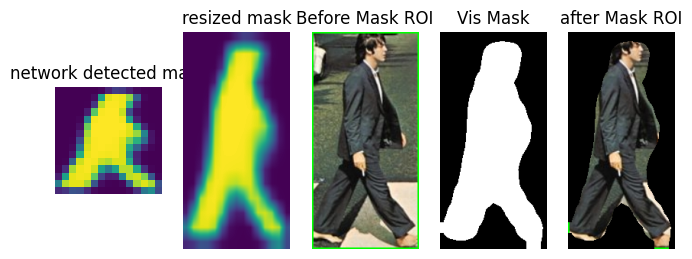

In [15]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(figsize=(8, 8), ncols=5, nrows=1)

ax1.set_title('network detected mask')
ax1.axis('off')
ax1.imshow(classMask)

ax2.set_title('resized mask')
ax2.axis('off')
ax2.imshow(scaled_classMask)


ax3.set_title('Before Mask ROI')
ax3.axis('off')
ax3.imshow(before_mask_roi)

ax4.set_title('Vis Mask')
ax4.axis('off')
ax4.imshow(vis_mask, cmap='gray')

ax5.set_title('after Mask ROI')
ax5.axis('off')
ax5.imshow(instance)

#### Detected된 object에 mask를 특정 투명 컬러로 적용후 시각화

In [16]:
draw_img[top:bottom+1, left:right+1].shape, draw_img[top:bottom+1, left:right+1][s_mask_b].shape # [s_mask_b]를 적용하면 해당 객체의 크기 중 True인 영역만 가져옴

((284, 140, 3), (19429, 3))

[80, 70, 180]


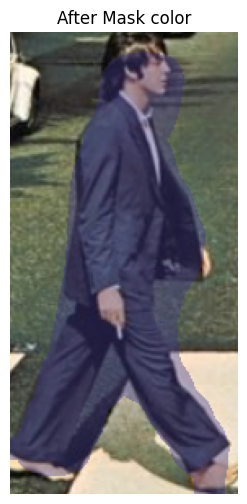

In [17]:
import numpy as np

draw_img = img_rgb.copy()

colorIndex = np.random.randint(0, len(colors)-1)
color = colors[colorIndex]
print(color)
after_mask_roi = draw_img[top:bottom+1, left:right+1][s_mask_b]
draw_img[top:bottom+1, left:right+1][s_mask_b] = ([0.3*color[0], 0.3*color[1], 0.3*color[2]] + 0.6 * after_mask_roi).astype(np.uint8)

plt.figure(figsize=(6,6))
plt.axis('off')
plt.title('After Mask color')
plt.imshow(draw_img[top:bottom+1, left:right+1])

In [18]:
print('object image shape:', draw_img[top:bottom+1, left:right+1].shape)
print('boolena object mask:', s_mask_b, s_mask_b.shape)
print('object masking boolen index 결과 shape:', draw_img[top:bottom+1, left:right+1][s_mask_b].shape)

object image shape: (284, 140, 3)
boolena object mask: [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]] (284, 140)
object masking boolen index 결과 shape: (19429, 3)


In [19]:
# 이런식으로 투명 color 적용할 수도 있음
print('투명 color 적용 1:', [0.3*color[0], 0.3*color[1], 0.3*color[2]])
print('투명 color 적용 2:', 0.6 * after_mask_roi)

투명 color 적용 1: [24.0, 21.0, 54.0]
투명 color 적용 2: [[57.  51.  43.8]
 [40.2 34.2 28.2]
 [30.6 24.6 18.6]
 ...
 [44.4 43.2 35.4]
 [49.2 49.2 42. ]
 [58.2 58.2 52.2]]


#### Mask 정보를 이용하여 Detect된 Object에 contour 윤곽선 적용.

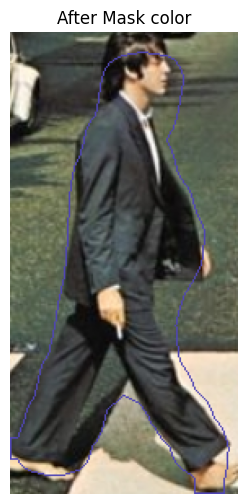

In [20]:
draw_img_01 = img_rgb.copy()

s_mask_i = s_mask_b.astype(np.uint8)
contours, hierarchy = cv2.findContours(s_mask_i,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(draw_img_01[top:bottom+1, left:right+1], contours, -1, color, 1, cv2.LINE_8, hierarchy, 100)

plt.figure(figsize=(6,6))
plt.axis('off')
plt.title('After Mask color')
plt.imshow(draw_img_01[top:bottom+1, left:right+1])

#### Detected된 Object들에 Mask 하여 시각화

Detect된 classMask shape: (15, 15)
원본 오브젝트 비율로 scale out된 classMask shape: (284, 140)
scaled mask shape: (284, 140) scaled mask pixel count: 39760 scaled mask true shape: (19429,) scaled mask False shape: (20331,)
before_mask_roi: (284, 140, 3)
Detect된 classMask shape: (15, 15)
원본 오브젝트 비율로 scale out된 classMask shape: (320, 151)
scaled mask shape: (320, 151) scaled mask pixel count: 48320 scaled mask true shape: (19727,) scaled mask False shape: (28593,)
before_mask_roi: (320, 151, 3)
Detect된 classMask shape: (15, 15)
원본 오브젝트 비율로 scale out된 classMask shape: (296, 178)
scaled mask shape: (296, 178) scaled mask pixel count: 52688 scaled mask true shape: (17478,) scaled mask False shape: (35210,)
before_mask_roi: (296, 178, 3)
Detect된 classMask shape: (15, 15)
원본 오브젝트 비율로 scale out된 classMask shape: (293, 163)
scaled mask shape: (293, 163) scaled mask pixel count: 47759 scaled mask true shape: (17652,) scaled mask False shape: (30107,)
before_mask_roi: (293, 163, 3)
Detect된 classMask shape:

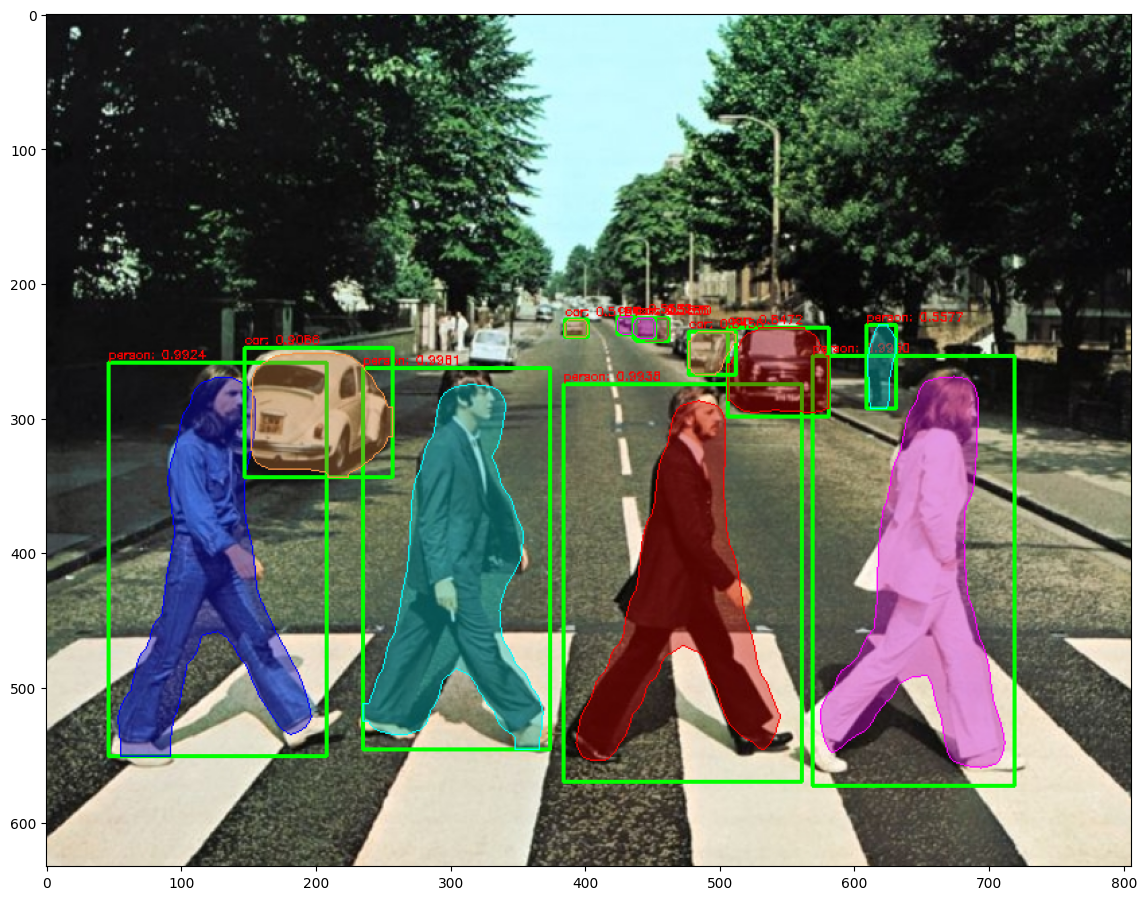

In [21]:
# 위의 코드 모아둔 것
import numpy as np

numClasses = masks.shape[1]
numDetections = boxes.shape[2]

# opencv의 rectangle(), putText() API는 인자로 들어온 IMAGE array에 그대로 수정작업을 수행하므로 bounding box 적용을 위한
# 별도의 image array 생성.
draw_img = img.copy()

img_height = draw_img.shape[0]
img_width = draw_img.shape[1]
conf_threshold = 0.5
mask_threshold = 0.3

green_color=(0, 255, 0)
red_color=(0, 0, 255)

for i in range(numDetections):
    box = boxes[0, 0, i]
    mask = masks[i]
    score = box[2]
    if score > conf_threshold:
        classId = int(box[1])
        left = int(img_width * box[3])
        top = int(img_height * box[4])
        right = int(img_width * box[5])
        bottom = int(img_height * box[6])

        text = "{}: {:.4f}".format(labels_to_names_seq[classId], score)
        cv2.rectangle(draw_img, (left, top), (right, bottom), green_color, thickness=2 )
        cv2.putText(draw_img, text, (left, top-3), cv2.FONT_HERSHEY_SIMPLEX, 0.3, red_color, 1)

        #### Detect된 Object에 대한 image mask 처리 수행을 위한 기본 정보 추출.
        # 네트웍 모델에서 반환된 detect된 object의 mask 정보 추출
        classMask = mask[classId]
        print('Detect된 classMask shape:', classMask.shape)
        # 원본 이미지의 object 크기에 맞춰 mask 크기 scale out
        scaled_classMask = cv2.resize(classMask, (right - left + 1, bottom - top + 1))
        print('원본 오브젝트 비율로 scale out된 classMask shape:', scaled_classMask.shape)
        # 지정된 mask Threshold 값 이상인지 True, False boolean형태의 mask 정보 생성.
        s_mask_b = (scaled_classMask > mask_threshold)
        print('scaled mask shape:', s_mask_b.shape, 'scaled mask pixel count:', s_mask_b.shape[0]*s_mask_b.shape[1],
              'scaled mask true shape:',s_mask_b[s_mask_b==True].shape,
              'scaled mask False shape:', s_mask_b[s_mask_b==False].shape)

        # mask를 적용할 bounding box 영역의 image 추출
        before_mask_roi = draw_img[top:bottom+1, left:right+1]
        print('before_mask_roi:', before_mask_roi.shape)
        # Detect된 Object에 mask를 특정 투명 컬러로 적용.
        colorIndex = np.random.randint(0, len(colors)-1)
        color = colors[colorIndex]
        after_mask_roi = draw_img[top:bottom+1, left:right+1][s_mask_b]
        draw_img[top:bottom+1, left:right+1][s_mask_b] = ([0.3*color[0], 0.3*color[1], 0.3*color[2]] + 0.6 * after_mask_roi).astype(np.uint8)
        # Detect된 Object에 윤곽선(contour) 적용.
        s_mask_i = s_mask_b.astype(np.uint8)
        contours, hierarchy = cv2.findContours(s_mask_i,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(draw_img[top:bottom+1, left:right+1], contours, -1, color, 1, cv2.LINE_8, hierarchy, 100)

plt.figure(figsize=(14, 14))
draw_img = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
plt.imshow(draw_img)
plt.show()

#### 단일 image Segmentation 함수 생성.

In [22]:
def get_box_info(box, img_width, img_height):

    classId = int(box[1])
    left = int(img_width * box[3])
    top = int(img_height * box[4])
    right = int(img_width * box[5])
    bottom = int(img_height * box[6])

    left = max(0, min(left, img_width - 1))
    top = max(0, min(top, img_height - 1))
    right = max(0, min(right, img_width - 1))
    bottom = max(0, min(bottom, img_height - 1))

    return classId, left, top, right, bottom


def draw_box(img_array, box, img_width, img_height, is_print=False):
    green_color=(0, 255, 0)
    red_color=(0, 0, 255)

    score = box[2]
    classId, left, top, right, bottom = get_box_info(box, img_width, img_height)
    text = "{}: {:.4f}".format(labels_to_names_seq[classId], score)

    if is_print:
        print("box:", box, "score:", score, "classId:", classId)

    cv2.rectangle(img_array, (left, top), (right, bottom), green_color, thickness=2 )
    cv2.putText(img_array, text, (left, top-3), cv2.FONT_HERSHEY_SIMPLEX, 0.5, red_color, thickness=1)

    return img_array

def draw_mask(img_array, box, mask, img_width, img_height, mask_threshold, is_print=False):

        classId, left, top, right, bottom = get_box_info(box, img_width, img_height)
        classMask = mask[classId]
        # 원본 이미지의 object 크기에 맞춰 mask 크기 scale out
        scaled_classMask = cv2.resize(classMask, (right - left + 1, bottom - top + 1))
        s_mask_b = (scaled_classMask > mask_threshold)
        before_mask_roi = img_array[top:bottom+1, left:right+1]

        # mask를 적용할 bounding box 영역의 image 추출하고 투명 color 적용.
        colorIndex = np.random.randint(0, len(colors)-1)
        color = colors[colorIndex]
        after_mask_roi = img_array[top:bottom+1, left:right+1][s_mask_b]
        img_array[top:bottom+1, left:right+1][s_mask_b] = ([0.3*color[0], 0.3*color[1], 0.3*color[2]] + 0.6 * after_mask_roi).astype(np.uint8)
        # Detect된 Object에 윤곽선(contour) 적용.
        s_mask_i = s_mask_b.astype(np.uint8)
        contours, hierarchy = cv2.findContours(s_mask_i,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(img_array[top:bottom+1, left:right+1], contours, -1, color, 1, cv2.LINE_8, hierarchy, 100)

        return img_array

In [23]:
import time

def detect_image_mask_rcnn(cv_net, img_array, conf_threshold, mask_threshold, use_copied_array, is_print=False):

    draw_img = None
    if use_copied_array:
        draw_img = img_array.copy()
        #draw_img = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
    else:
        draw_img = img_array

    start_time = time.time()

    blob = cv2.dnn.blobFromImage(img_array, swapRB=True, crop=False)
    cv_net.setInput(blob)
    boxes, masks = cv_net.forward(['detection_out_final', 'detection_masks'])

    inference_time = time.time() - start_time
    if is_print:
        print('Segmentation Inference time {0:}'.format(inference_time))

    numClasses = masks.shape[1]
    numDetections = boxes.shape[2]

    img_height = img_array.shape[0]
    img_width = img_array.shape[1]

    for i in range(numDetections):
        box = boxes[0, 0, i]
        mask = masks[i]
        score = box[2]
        #print("score:", score)
        if score > conf_threshold:
            draw_box(img_array , box, img_width, img_height, is_print=is_print)
            draw_mask(img_array, box, mask, img_width, img_height, mask_threshold, is_print=is_print)

    return img_array

In [24]:
labels_to_names_seq = {0:'person',1:'bicycle',2:'car',3:'motorcycle',4:'airplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',
                    10:'fire hydrant',11:'street sign',12:'stop sign',13:'parking meter',14:'bench',15:'bird',16:'cat',17:'dog',18:'horse',19:'sheep',
                    20:'cow',21:'elephant',22:'bear',23:'zebra',24:'giraffe',25:'hat',26:'backpack',27:'umbrella',28:'shoe',29:'eye glasses',
                    30:'handbag',31:'tie',32:'suitcase',33:'frisbee',34:'skis',35:'snowboard',36:'sports ball',37:'kite',38:'baseball bat',39:'baseball glove',
                    40:'skateboard',41:'surfboard',42:'tennis racket',43:'bottle',44:'plate',45:'wine glass',46:'cup',47:'fork',48:'knife',49:'spoon',
                    50:'bowl',51:'banana',52:'apple',53:'sandwich',54:'orange',55:'broccoli',56:'carrot',57:'hot dog',58:'pizza',59:'donut',
                    60:'cake',61:'chair',62:'couch',63:'potted plant',64:'bed',65:'mirror',66:'dining table',67:'window',68:'desk',69:'toilet',
                    70:'door',71:'tv',72:'laptop',73:'mouse',74:'remote',75:'keyboard',76:'cell phone',77:'microwave',78:'oven',79:'toaster',
                    80:'sink',81:'refrigerator',82:'blender',83:'book',84:'clock',85:'vase',86:'scissors',87:'teddy bear',88:'hair drier',89:'toothbrush',
                    90:'hair brush'}

image shape: (633, 806, 3)
Segmentation Inference time 6.505905866622925
box: [0.         0.         0.99608445 0.29211444 0.416256   0.46419758
 0.863864  ] score: 0.99608445 classId: 0
box: [0.         0.         0.99503857 0.7070573  0.40266553 0.8928599
 0.90648496] score: 0.99503857 classId: 0
box: [0.         0.         0.99379796 0.47765705 0.4357019  0.69640374
 0.90162915] score: 0.99379796 classId: 0
box: [0.         0.         0.9923969  0.05819514 0.41030937 0.25875422
 0.87195414] score: 0.9923969 classId: 0
box: [0.         2.         0.90857524 0.18292084 0.39299953 0.31934735
 0.54407126] score: 0.90857524 classId: 2
box: [0.         2.         0.84718364 0.6288681  0.36894062 0.72099614
 0.47316423] score: 0.84718364 classId: 2
box: [0.         2.         0.84555095 0.5919427  0.37339947 0.6360404
 0.4248989 ] score: 0.84555095 classId: 2
box: [0.         2.         0.5830004  0.5437924  0.35812193 0.57419306
 0.3843462 ] score: 0.5830004 classId: 2
box: [0.         0.

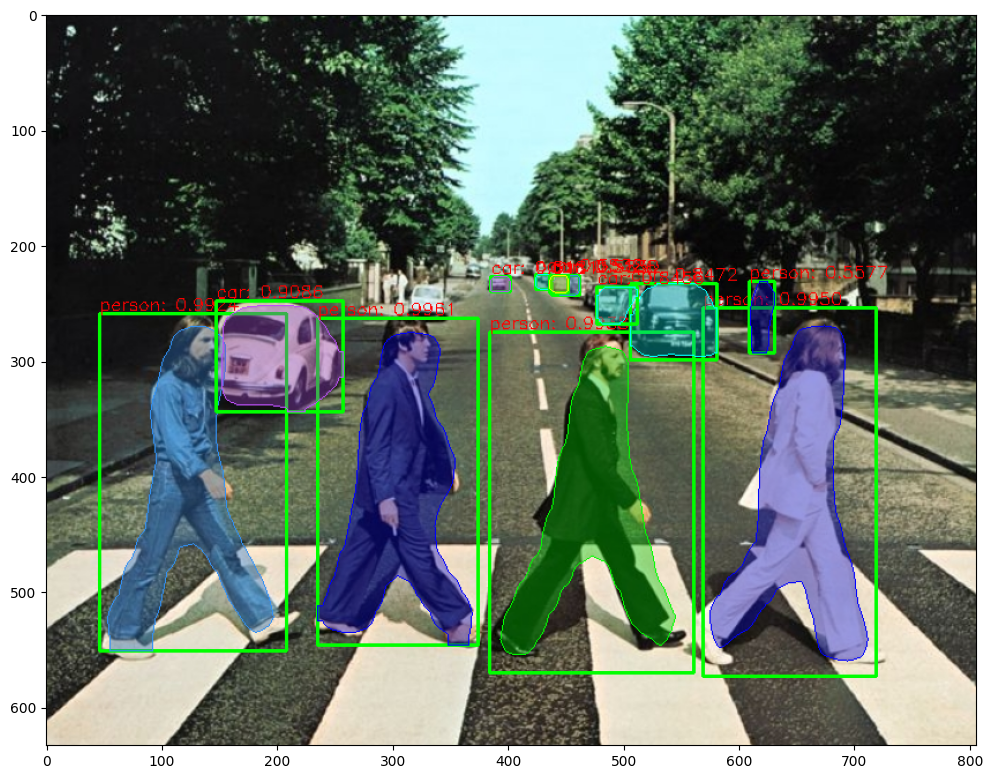

In [26]:
import os
# image 로드
img = cv2.imread('./data/beatles01.jpg')
print('image shape:', img.shape)

cv_net = cv2.dnn.readNetFromTensorflow('./pretrained/mask_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb',
                                     './pretrained/config_mask_graph.pbtxt')

img_detected = detect_image_mask_rcnn(cv_net, img, conf_threshold=0.5, mask_threshold=0.3, use_copied_array=True, is_print=True)

img_rgb = cv2.cvtColor(img_detected, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

#### 다른 이미지 파일에 Segmentation 수행하기

In [27]:
!wget -O ./data/baseball01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/baseball01.jpg

--2023-11-18 09:20:55--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/baseball01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76279 (74K) [image/jpeg]
Saving to: ‘./data/baseball01.jpg’

./data/baseball01.j 100%[===================>]  74.49K  --.-KB/s    in 0.03s   

2023-11-18 09:20:55 (2.87 MB/s) - ‘./data/baseball01.jpg’ saved [76279/76279]



image shape: (476, 735, 3)
Segmentation Inference time 6.9817681312561035
box: [0.         0.         0.99785644 0.04259906 0.42621613 0.25663814
 0.93009865] score: 0.99785644 classId: 0
box: [0.         0.         0.9975453  0.43244982 0.2681948  0.6785289
 0.83997023] score: 0.9975453 classId: 0
box: [0.         0.         0.9971505  0.23768514 0.5497622  0.4551344
 0.9489499 ] score: 0.9971505 classId: 0
box: [ 0.         39.          0.9102637   0.44959116  0.6338691   0.5190123
  0.7239937 ] score: 0.9102637 classId: 39
box: [ 0.         38.          0.8011309   0.6458585   0.46479815  0.82042885
  0.5484391 ] score: 0.8011309 classId: 38
box: [ 0.         36.          0.3160459   0.8908464   0.467275    0.9115547
  0.50015014] score: 0.3160459 classId: 36


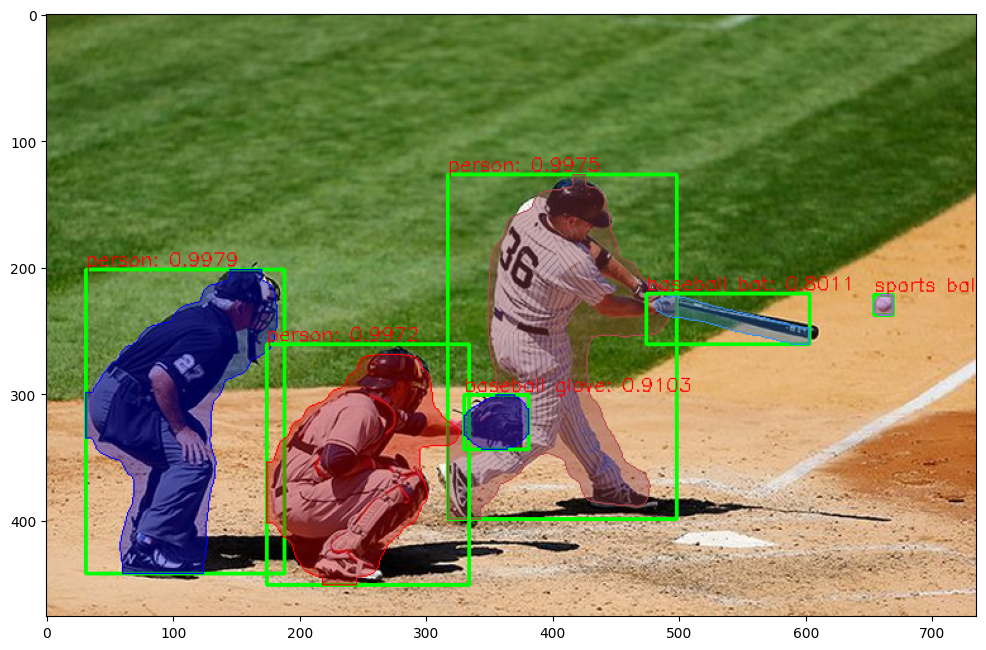

In [28]:
import os
# image 로드
img = cv2.imread('./data/baseball01.jpg')
print('image shape:', img.shape)

cv_net = cv2.dnn.readNetFromTensorflow('./pretrained/mask_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb',
                                     './pretrained/config_mask_graph.pbtxt')

# 야구공이 mask detect 되지 않아서 conf_threshold와 mask_threshold 를 낮춤.
img_detected = detect_image_mask_rcnn(cv_net, img, conf_threshold=0.3, mask_threshold=0.2, use_copied_array=True, is_print=True)

img_rgb = cv2.cvtColor(img_detected, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

#### 영상에 Segmentation 적용

In [29]:
!wget -O ./data/John_Wick_small.mp4 https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/John_Wick_small.mp4

--2023-11-18 09:21:05--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/John_Wick_small.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1794863 (1.7M) [application/octet-stream]
Saving to: ‘./data/John_Wick_small.mp4’

./data/John_Wick_sm 100%[===================>]   1.71M  --.-KB/s    in 0.08s   

2023-11-18 09:21:05 (22.2 MB/s) - ‘./data/John_Wick_small.mp4’ saved [1794863/1794863]



In [30]:
def detect_video_mask_rcnn(cv_net, input_path, output_path, conf_threshold, mask_threshold,  is_print):

    cap = cv2.VideoCapture(input_path)

    codec = cv2.VideoWriter_fourcc(*'XVID')

    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)

    vid_writer = cv2.VideoWriter(output_path, codec, 24, vid_size)

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt, )

    frame_index=0
    while True:
        hasFrame, img_frame = cap.read()
        frame_index += 1
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다.')
            break
        print("frame index:{0:}".format(frame_index), end=" ")
        returned_frame = detect_image_mask_rcnn(cv_net, img_frame, conf_threshold=conf_threshold,
                                                mask_threshold=mask_threshold,use_copied_array=False, is_print=is_print)
        vid_writer.write(returned_frame)
    # end of while loop

    vid_writer.release()
    cap.release()

In [31]:
cv_net = cv2.dnn.readNetFromTensorflow('./pretrained/mask_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb',
                                     './pretrained/config_mask_graph.pbtxt')

detect_video_mask_rcnn(cv_net,'/content/data/John_Wick_small.mp4', '/content/data/John_Wick_mask_01.avi',
                      conf_threshold=0.5, mask_threshold=0.3, is_print=True)

총 Frame 갯수: 58
frame index:1 Segmentation Inference time 8.534870624542236
box: [0.         2.         0.9897792  0.86242795 0.3607604  0.99989486
 0.8309683 ] score: 0.9897792 classId: 2
box: [0.         2.         0.9701184  0.         0.29770762 0.16895667
 0.73839873] score: 0.9701184 classId: 2
box: [0.         2.         0.9561754  0.12571147 0.38014138 0.4003646
 0.759598  ] score: 0.9561754 classId: 2
box: [0.         2.         0.9518084  0.75568426 0.5090502  0.8552731
 0.7149634 ] score: 0.9518084 classId: 2
box: [0.         2.         0.7611341  0.7179851  0.53895605 0.78393286
 0.6857109 ] score: 0.7611341 classId: 2
box: [0.         0.         0.55496705 0.41242647 0.01324415 0.61356187
 0.6925207 ] score: 0.55496705 classId: 0
box: [0.         0.         0.520103   0.65576553 0.41798288 0.724867
 0.63431805] score: 0.520103 classId: 0
frame index:2 Segmentation Inference time 5.5081140995025635
box: [0.         2.         0.9903396  0.8629229  0.36098033 0.9998951
 0.834